# **Credit Card Fraud Detection Using Deep Autoencoder**

### **Import Modules**

In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import auc, roc_curve, confusion_matrix

from tqdm import tqdm_notebook as tqdm

### **Load Dataset (https://www.kaggle.com/mlg-ulb/creditcardfraud)**

In [2]:
credit_card_transaction_data = pd.read_csv('./drive/My Drive/creditcard.csv')
cctd = credit_card_transaction_data
cctd.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### **Observe the Dataset**

In [3]:
normal_DF = cctd[cctd.Class == 0]
fraud_DF = cctd[cctd.Class == 1]

print('Total Shape: ', cctd.shape)
print('Normal Shape: ', normal_DF.shape)
print('Fraud Shape: ', fraud_DF.shape)
print('-------------------------------------')
print('-------------------------------------')
print('Normal Amount Description:')
print(normal_DF.Amount.describe())
print('-------------------------------------')
print('-------------------------------------')
print('Fraud Amount Description:')
print(fraud_DF.Amount.describe())

Total Shape:  (284807, 31)
Normal Shape:  (284315, 31)
Fraud Shape:  (492, 31)
-------------------------------------
-------------------------------------
Normal Amount Description:
count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64
-------------------------------------
-------------------------------------
Fraud Amount Description:
count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64


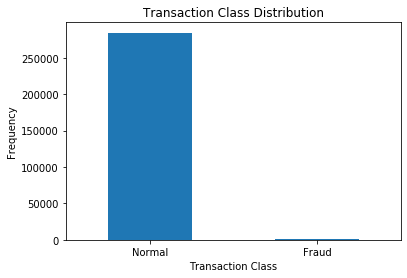

In [4]:
LABELS = ["Normal", "Fraud"]

count_classes = pd.value_counts(cctd['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction Class Distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Transaction Class")
plt.ylabel("Frequency")
plt.show()

# This cell is from https://github.com/curiousily/Credit-Card-Fraud-Detection-using-Autoencoders-in-Keras

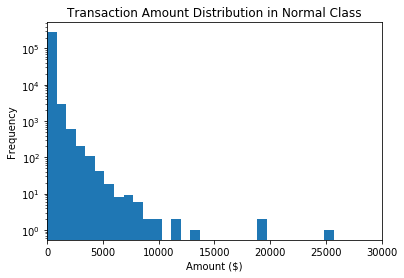

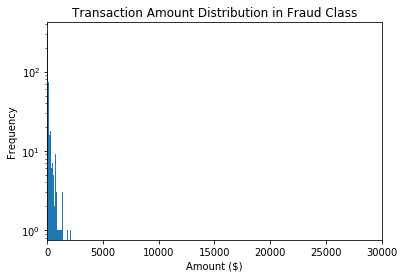

In [5]:
bins = 30

plt.hist(normal_DF.Amount, bins = bins)
plt.title('Transaction Amount Distribution in Normal Class')
plt.ylabel('Frequency')
plt.xlabel('Amount ($)')
plt.yscale('log')
plt.xlim((0, 30000))
plt.show()

plt.hist(fraud_DF.Amount, bins = bins)
plt.title('Transaction Amount Distribution in Fraud Class')
plt.ylabel('Frequency')
plt.xlabel('Amount ($)')
plt.yscale('log')
plt.xlim((0, 30000))
plt.show()

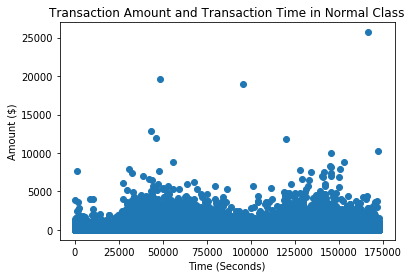

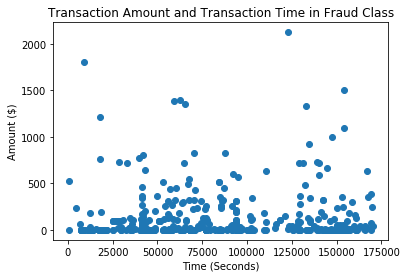

In [6]:
plt.scatter(normal_DF.Time, normal_DF.Amount)
plt.title('Transaction Amount and Transaction Time in Normal Class')
plt.ylabel('Amount ($)')
plt.xlabel('Time (Seconds)')
plt.show()

plt.scatter(fraud_DF.Time, fraud_DF.Amount)
plt.title('Transaction Amount and Transaction Time in Fraud Class')
plt.ylabel('Amount ($)')
plt.xlabel('Time (Seconds)')
plt.show()

### **Design Model Class**

In [0]:
class Autoencoder(nn.Module):

    def __init__(self):
        super(Autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(30, 12),
            nn.Tanh(),
            nn.Linear(12, 5),
            nn.ReLU(),
            )

        self.decoder = nn.Sequential(
           nn.Linear(5, 12),
           nn.Tanh(),
           nn.Linear(12, 30),
           nn.ReLU()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)

        return x

### **Design Metrics Function**

In [0]:
def calculate_metrics():

    def_val_losses = []

    # def_optimal_autoencoder_model = Autoencoder().double()
    # def_optimal_autoencoder_model.load_state_dict(torch.load('./credit_card_fraud_detection_model'))
    # def_optimal_autoencoder_model.eval()

    with torch.no_grad():

        for def_j, def_test_data in enumerate(test_loader):
            def_test_input = def_test_data
            # print(def_test_input)
            def_test_output = autoencoder_model(def_test_input)
            def_test_loss = criterion(def_test_output, def_test_input).data.item()
            # print(def_test_loss)
            def_val_losses.append(def_test_loss)
    
    np_def_val_losses = np.array(def_val_losses)

    def_error_DF = pd.DataFrame({'def_val_loss': np_def_val_losses, 'Class': y_test})


    def_fpr, def_tpr, def_thresholds = roc_curve(def_error_DF.Class, def_error_DF.def_val_loss)

    def_i = np.arange(len(def_tpr))
    def_roc = pd.DataFrame(
        {'fpr': pd.Series(def_fpr, index=def_i),
        'tpr': pd.Series(def_tpr, index=def_i),
        'total_tf': pd.Series(def_tpr+def_fpr-1, index=def_i),
        'thresholds': pd.Series(def_thresholds, index=def_i)
        }
    )

    def_threshold = def_roc.thresholds[(def_roc.total_tf-0).abs().argsort()[0]]


    def_pred_y = np.array([1 if def_error > def_threshold else 0 for def_error in def_error_DF.def_val_loss.values])
    def_conf_matrix = confusion_matrix(def_pred_y, def_error_DF.Class)

    # cctd_Accuracy = ((def_conf_matrix[0][0]+def_conf_matrix[1][1]) / 
            # (def_conf_matrix[0][0]+def_conf_matrix[0][1]+def_conf_matrix[1][0]+def_conf_matrix[1][1]))
    # cctd_Precision = def_conf_matrix[0][0] / (def_conf_matrix[0][0]+def_conf_matrix[0][1])
    # cctd_Recall = def_conf_matrix[0][0] / (def_conf_matrix[0][0]+def_conf_matrix[1][0])
    # cctd_F_measure = (2 * cctd_Precision * cctd_Recall) / (cctd_Precision + cctd_Recall)

    # cctd_True_Positive_Rate = def_conf_matrix[0][0] / (def_conf_matrix[0][0]+def_conf_matrix[1][0])
    # cctd_False_Positive_Rate = def_conf_matrix[0][1] / (def_conf_matrix[0][1]+def_conf_matrix[1][1])
    # cctd_True_Negative_Rate = def_conf_matrix[1][1] / (def_conf_matrix[0][1]+def_conf_matrix[1][1])

    reversed_precision = def_conf_matrix[1][1] / (def_conf_matrix[1][0]+def_conf_matrix[1][1])
    reversed_recall = def_conf_matrix[1][1] / (def_conf_matrix[0][1]+def_conf_matrix[1][1])
    reversed_F_measure = (2 * reversed_precision * reversed_recall) / (reversed_precision + reversed_recall)

    # return cctd_F_measure

    return reversed_F_measure

### **Data Preprocessing**

In [0]:
cctd['Time'] = StandardScaler().fit_transform(cctd['Time'].values.reshape(-1, 1))
cctd['Amount'] = StandardScaler().fit_transform(cctd['Amount'].values.reshape(-1, 1))

X_train, X_test = train_test_split(cctd, test_size=0.2, random_state=99)

X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)
# print(type(X_train))

y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)

X_train = X_train.values
# print(type(X_train))
X_test = X_test.values
y_test = y_test.values

# print(type(y_test))

# print(X_train.shape)
# print(X_test.shape)
# print(y_test.shape)

# This cell is mainly from https://github.com/curiousily/Credit-Card-Fraud-Detection-using-Autoencoders-in-Keras

### **Build Model**

In [0]:
autoencoder_model = Autoencoder().double()

total_epochs = 40
batchsize = 32

os.makedirs('./drive/My Drive/model', exist_ok=True)

train_loader = DataLoader(X_train, batch_size = batchsize, shuffle = True)

test_loader = DataLoader(X_test, batch_size = 1, shuffle = False)

# print(len(train_loader))
# print(len(test_loader))

criterion = nn.MSELoss()

optimizer = torch.optim.Adam(autoencoder_model.parameters(), lr = 0.001)

### **Train Model**

In [11]:
max_f_measure = 0
# min_loss = 20191129

train_losses = []
test_losses = []

for epoch in tqdm(range(total_epochs)):

    total_train_loss = 0.0
    n = 0

    for i, train_data in enumerate(train_loader):

        train_input = train_data
        # print(train_input)
        # print(type(train_input))
        optimizer.zero_grad()

        train_output = autoencoder_model(train_input)
        train_loss = criterion(train_output, train_input)
        total_train_loss += train_loss.item()
        n += 1

        train_loss.backward()
        optimizer.step()

    # print(n)
    mean_train_loss = total_train_loss / n
    
    train_losses.append(mean_train_loss)
    np_train_losses = np.array(train_losses)

    # print('[Epoch: %d/%d], Train Loss: %f' % 
    # (epoch + 1, total_epochs, mean_train_loss))


    with torch.no_grad():

        total_test_loss = 0.0
        m = 0
        
        for j, test_data in enumerate(test_loader):
            
            test_input = test_data
            # print(test_input)
            test_output = autoencoder_model(test_input)
            test_loss = criterion(test_output, test_input)
            # print(test_loss)
            total_test_loss += test_loss.item()
            m += 1

        # print(m)
        mean_test_loss = total_test_loss / m

        test_losses.append(mean_test_loss)
        np_test_losses = np.array(test_losses)

    print('[Epoch: %d/%d], Train Loss: %f, Test Loss: %f' % 
        (epoch + 1, total_epochs, mean_train_loss, mean_test_loss))
    


    f_measure0 = calculate_metrics()

    # print('F: ', f_measure0)

    # if mean_test_loss < min_loss:

    if f_measure0 > max_f_measure:

        # min_loss = mean_test_loss
        
        max_f_measure = f_measure0

        # print('epoch ', epoch + 1, ' is the best model now !!!')
        # torch.save(autoencoder_model.state_dict(), './credit_card_fraud_detection_model')
        torch.save(autoencoder_model.state_dict(), './drive/My Drive/model/credit_card_fraud_detection_model')

[Epoch: 1/40], Train Loss: 0.835820, Test Loss: 0.851576
[Epoch: 2/40], Train Loss: 0.777910, Test Loss: 0.828945
[Epoch: 3/40], Train Loss: 0.766150, Test Loss: 0.820644
[Epoch: 4/40], Train Loss: 0.760252, Test Loss: 0.815769
[Epoch: 5/40], Train Loss: 0.756115, Test Loss: 0.814014
[Epoch: 6/40], Train Loss: 0.753947, Test Loss: 0.811002
[Epoch: 7/40], Train Loss: 0.751918, Test Loss: 0.809263
[Epoch: 8/40], Train Loss: 0.750250, Test Loss: 0.808504
[Epoch: 9/40], Train Loss: 0.749665, Test Loss: 0.806793
[Epoch: 10/40], Train Loss: 0.748385, Test Loss: 0.806527
[Epoch: 11/40], Train Loss: 0.747878, Test Loss: 0.805673
[Epoch: 12/40], Train Loss: 0.746962, Test Loss: 0.804989
[Epoch: 13/40], Train Loss: 0.746233, Test Loss: 0.805517
[Epoch: 14/40], Train Loss: 0.745916, Test Loss: 0.803423
[Epoch: 15/40], Train Loss: 0.744780, Test Loss: 0.802346
[Epoch: 16/40], Train Loss: 0.743478, Test Loss: 0.800922
[Epoch: 17/40], Train Loss: 0.742719, Test Loss: 0.802267
[Epoch: 18/40], Train L

### **Evaluate Model**

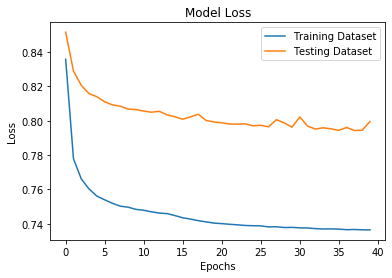

In [12]:
plt.plot(np_train_losses)
plt.plot(np_test_losses)
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training Dataset', 'Testing Dataset'])
plt.show()

In [13]:
optimal_autoencoder_model = Autoencoder().double()
optimal_autoencoder_model.load_state_dict(torch.load('./drive/My Drive/model/credit_card_fraud_detection_model'))
optimal_autoencoder_model.eval()

val_losses = []

with torch.no_grad():
    for k, data in enumerate(test_loader):
        test_inputs = data
        # print(test_inputs)
        test_outputs = optimal_autoencoder_model(test_inputs)
        # print(type(test_outputs))
        # print(test_outputs.shape)
        loss = criterion(test_outputs, test_inputs).item()
        # print(type(loss))
        # print(loss)
        # print(loss.shape)
        # loss = loss.item()
        # print(type(loss))
        # print(loss)
        # print(loss.shape)        
        val_losses.append(loss)

np_val_losses = np.array(val_losses)

test_error_DF = pd.DataFrame({'val_loss': np_val_losses, 'Class': y_test})

test_error_DF.describe()

,val_loss,Class
count,56962.000000,56962.000000
mean,0.815769,0.001791
std,3.775532,0.042279
min,0.063380,0.000000
25%,0.290732,0.000000
50%,0.444930,0.000000
75%,0.689105,0.000000
max,302.963144,1.000000


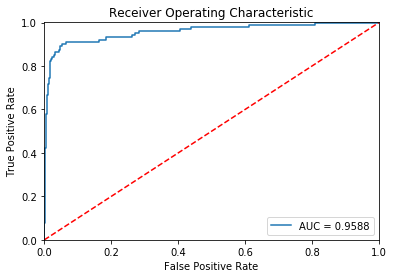

In [14]:
fpr, tpr, thresholds = roc_curve(test_error_DF.Class, test_error_DF.val_loss)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# This cell is from https://github.com/curiousily/Credit-Card-Fraud-Detection-using-Autoencoders-in-Keras

### **Calculate Optimal Threshold**

In [15]:
j = np.array([i for i in range(len(tpr))])

roc = pd.DataFrame(
    {'fpr': pd.Series(fpr, index = j),
     'tpr': pd.Series(tpr, index = j),
     'total_tf': pd.Series(tpr+fpr-1, index = j),
     'thresholds': pd.Series(thresholds, index = j)
    }
)

print('Index corresponding to Optimal Threshold: ', (roc.total_tf-0).abs().argsort()[0])
print('Optimal Threshold: ', roc.thresholds[(roc.total_tf-0).abs().argsort()[0]])
threshold = roc.thresholds[(roc.total_tf-0).abs().argsort()[0]]

# (roc.total_tf-0).abs().argsort()[0:1]
roc.iloc[(roc.total_tf-0).abs().argsort()[0:1]]

Index corresponding to Optimal Threshold:  169
Optimal Threshold:  1.248372447853373


,fpr,tpr,total_tf,thresholds
169,0.075343,0.911765,-0.012892,1.248372


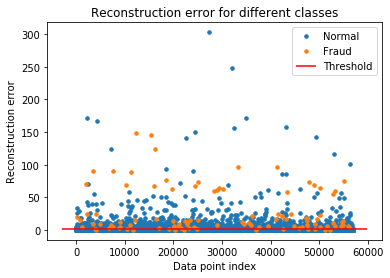

In [16]:
groups = test_error_DF.groupby('Class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.val_loss, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()

# This cell is from https://github.com/curiousily/Credit-Card-Fraud-Detection-using-Autoencoders-in-Keras

### **Build Confusion Matrix and Calculate Metrics**

In [17]:
pred_y = np.array([1 if error > threshold else 0 for error in test_error_DF.val_loss.values])
conf_matrix = confusion_matrix(pred_y, test_error_DF.Class)
print(conf_matrix)

cctd_Accuracy = ((conf_matrix[0][0]+conf_matrix[1][1]) / 
            (conf_matrix[0][0]+conf_matrix[0][1]+conf_matrix[1][0]+conf_matrix[1][1]))
cctd_Precision = conf_matrix[0][0] / (conf_matrix[0][0]+conf_matrix[0][1])
cctd_Recall = conf_matrix[0][0] / (conf_matrix[0][0]+conf_matrix[1][0])
cctd_F_measure = (2 * cctd_Precision * cctd_Recall) / (cctd_Precision + cctd_Recall)

cctd_True_Positive_Rate = conf_matrix[0][0] / (conf_matrix[0][0]+conf_matrix[1][0])
cctd_False_Positive_Rate = conf_matrix[0][1] / (conf_matrix[0][1]+conf_matrix[1][1])
cctd_True_Negative_Rate = conf_matrix[1][1] / (conf_matrix[0][1]+conf_matrix[1][1])

print('----------------------------------------------')
print('----------------------------------------------')

print('Accuracy: ', round(cctd_Accuracy, 5))
print('Precision: ', round(cctd_Precision, 5))
print('Recall: ', round(cctd_Recall, 5))
print('F-measure: ', round(cctd_F_measure, 5))
print('True Positive Rate (TPR): ', round(cctd_True_Positive_Rate, 5))
print('False Positive Rate (FPR): ', round(cctd_False_Positive_Rate, 5))
print('True Negative Rate: ', round(cctd_True_Negative_Rate, 5))

[[52578     9]
 [ 4282    93]]
----------------------------------------------
----------------------------------------------
Accuracy:  0.92467
Precision:  0.99983
Recall:  0.92469
F-measure:  0.96079
True Positive Rate (TPR):  0.92469
False Positive Rate (FPR):  0.08824
True Negative Rate:  0.91176
